# REINFORCE Algorithm test

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import logging
import os
import random
import sys
import warnings
from itertools import accumulate

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

ROOT_FOLDER = os.path.join(".", "..")
if ROOT_FOLDER not in sys.path:
    sys.path.insert(0, ROOT_FOLDER)


from dataset import RegexDataset
from environment_metrics import Environment, EnvSettings

warnings.filterwarnings("ignore")
logging.disable(logging.WARNING)
torch.backends.cudnn.deterministic = True
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

## Utils

In [25]:
def set_seed(seed: int = 420):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

## Dataset

In [26]:
dataset = RegexDataset(["a2d", "2bb"], r"\d+")
data_iter = dataset.create_iterator()

for i in range(10):
    print(next(data_iter))

('a2d', [0, 1, 0], 1)
('2bb', [1, 0, 0], 1)
('a2d', [0, 1, 0], 1)
('2bb', [1, 0, 0], 1)
('2bb', [1, 0, 0], 1)
('a2d', [0, 1, 0], 1)
('2bb', [1, 0, 0], 1)
('a2d', [0, 1, 0], 1)
('a2d', [0, 1, 0], 1)
('2bb', [1, 0, 0], 1)


## Environment

In [27]:
env = Environment(dataset, settings=EnvSettings(max_steps=10))

env.action_space

101

In [28]:
env.state_space

10

In [29]:
state = env.reset()
for _ in range(6):
    action = np.random.randint(env.action_space)
    print(f"{action=}")
    print(env.step(action))

action=72
(array([0.71287129, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 0, False)
action=6
(array([0.71287129, 0.05940594, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 0, False)
action=63
(array([0.71287129, 0.05940594, 0.62376238, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 0, False)
action=31
(array([0.71287129, 0.05940594, 0.62376238, 0.30693069, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 0, False)
action=46
(array([0.71287129, 0.05940594, 0.62376238, 0.30693069, 0.45544554,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 0, False)
action=57
(array([0.71287129, 0.05940594, 0.62376238, 0.30693069, 0.45544554,
       0.56435644, 1.        , 1.        , 1.        , 1.        ]), 0, False)


## REINFORCE

In [30]:
def calculate_qvals(
    rewards: list[float] | np.ndarray, gamma: float = 1, reward_steps: int = 0
) -> np.ndarray:
    rw_steps = reward_steps if reward_steps != 0 else len(rewards)

    return np.array(
        [
            list(
                accumulate(
                    reversed(rewards[i : i + rw_steps]), lambda x, y: gamma * x + y
                )
            )[-1]
            for i in range(len(rewards))
        ]
    )

In [31]:
class PGN(nn.Module):
    def __init__(
        self,
        input_dim: int = env.state_space,
        output_dim: int = env.action_space,
        hidden_dim: int = 64,
    ) -> None:
        super(PGN, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64,128),
            nn.Tanh(),
            nn.Linear(128, output_dim),
        )

    def forward(self, x):
        return self.net(x)

## Agent

In [32]:
class Agent:
    def choose_action(self, action_logits: torch.Tensor):
        return np.random.choice(
            range(len(action_logits)), size=1, p=F.softmax(action_logits, dim=0).numpy()
        )[0]
    def choose_random(self, action_logits):
        return np.random.choice(range(len(action_logits)))

    def choose_optimal_action(self, action_logits: torch.Tensor) -> int:
        return int(np.argmax(F.softmax(action_logits, dim=0).cpu()).item())

## Trajectory Buffer

In [33]:
class TrajectoryBuffer:
    """
    Buffer class to store the experience from a unique policy
    """

    def _batch(self, iterable):
        ln = len(iterable)
        for ndx in range(0, ln, self.batch_size):
            yield iterable[ndx : min(ndx + self.batch_size, ln)]

    def __init__(self, batch_size: int = 64):
        self.batch_size = batch_size
        self.clean()

    def clean(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.discounted_rewards = []

    def store(
        self,
        states_trajectory: np.ndarray,
        trajectory: np.ndarray,
    ):
        """
        Add trajectory values to the buffers and compute the advantage and reward to go

        Parameters:
        -----------
        states_trajectory:  list that contains states
        trajectory: list where each element is a list that contains: reward, action
        """
        assert len(states_trajectory) == len(trajectory)

        if len(states_trajectory) > 0:
            self.states.extend(states_trajectory)
            self.rewards.extend(trajectory[:, 0])
            self.actions.extend(trajectory[:, 1])

            self.discounted_rewards.extend(calculate_qvals(trajectory[:, 0]))

    def get_batches(self, mean_baseline: bool):
        if mean_baseline:
            mean_rewards = np.mean(self.discounted_rewards)
        else:
            mean_rewards = 0

        for states_batch, actions_batch, discounted_rewards_batch in zip(
            self._batch(self.states),
            self._batch(self.actions),
            self._batch(self.discounted_rewards),
        ):
            mean_reward = (discounted_rewards_batch - np.mean(discounted_rewards_batch))  / (np.std(discounted_rewards_batch) + 1e-8)
            yield (
                torch.tensor(states_batch, dtype=torch.float32, device=DEVICE),
                torch.tensor(actions_batch, dtype=torch.long, device=DEVICE),
                torch.tensor(
                    np.array(discounted_rewards_batch) - mean_rewards,
                    dtype=torch.float,
                    device=DEVICE,
                ),
            )

    def __len__(self):
        return len(self.states)

## Evaluation

TBD: generate one Regex and test it on dataset

In [34]:
def evaluate(
    pgn_net: nn.Module,
    env: Environment,
    agent: Agent,
    verbose: bool = True,
) -> tuple[str, float]:

    pgn_net.eval()
    max_steps =  env.settings.max_steps
    state = env.reset()
    regex_actions = []
    total_reward = 0.0
    done = False
    
    with torch.no_grad():
        for _ in range(max_steps):
            state_tensor = torch.tensor(state, dtype=torch.float32, device=DEVICE)
            action_logits = pgn_net(state_tensor)
            
           
            action = agent.choose_optimal_action(action_logits)
            regex_actions.append(env.idx_to_action(action))
            
           
            next_state, reward, done = env.step(action)
            total_reward += reward
            
            if done:
                break
            state = next_state

    if regex_actions and regex_actions[-1] == env._finish_action:
        regex_actions = regex_actions[:-1]
    
    try:
        regex = env.rpn.to_infix(regex_actions)
    except Exception as e:
        regex = f"Invalid: {regex_actions}"
    
    if verbose:
        print(f"Generated regex: {regex}")
        print(f"Total reward: {total_reward:.2f}")
    
    return regex, total_reward

## Training

In [35]:
def train_loop(
    pgn_net: nn.Module,
    pgn_optimizer: optim.Optimizer,
    agent: Agent,
    buffer: TrajectoryBuffer,
    epochs: int,
    episodes: int,
    mean_baseline: bool = True,
    entropy_beta: float = 1,
):
    arr_rewards = []
    pgn_net.train()
    for i in range(1, epochs + 1):
        buffer.clean()
        state = env.reset()
        done_episodes = 0
        ep_states_buf, ep_rew_act_buf = [], []
        reg_exp = []
        train_rewards = []

        epoch_loop = tqdm(total=episodes, desc=f"Epoch #{i}", position=0, disable=True)

        while done_episodes < episodes:
            state_tensor = torch.tensor(state, dtype=torch.float32, device=DEVICE)

            with torch.no_grad():
                action_logits = pgn_net(state_tensor)

            # if i < epochs // 5:
            #     action = agent.choose_random(action_logits)
            # else:
            
            # mx = torch.max(torch.abs(action_logits))
            t = 1/np.sqrt(i)
            
            action = agent.choose_action(action_logits/t)
                
            
            next_state, reward, done = env.step(action)
            
            reg_exp.append(env.idx_to_action(action))

            ep_states_buf.append(state)
            ep_rew_act_buf.append([reward, int(action)])

            state = next_state
            if done:
                buffer.store(
                    np.array(ep_states_buf),
                    np.array(ep_rew_act_buf),
                )

                ep_states_buf, ep_rew_act_buf = [], []

                train_rewards.append(reward)
                arr_rewards.append(train_rewards)
                done_episodes += 1
                epoch_loop.update(1)

        losses = []
        for batch in buffer.get_batches(mean_baseline):
            pgn_optimizer.zero_grad()
            (
                state_batch,
                action_batch,
                reward_batch,
            ) = batch
           

            logits_v = pgn_net(state_batch)

            log_prob_v = F.log_softmax(logits_v , dim=1)

            log_prob_actions_v = (
                reward_batch * log_prob_v[range(len(state_batch)), action_batch]
            )
            loss_policy_v = -log_prob_actions_v.mean()

            prob_v = F.softmax(logits_v, dim=1)
            entropy_v = -(prob_v * log_prob_v).sum(dim=1).mean()
            entropy_loss_v = entropy_beta * entropy_v
            loss_v = loss_policy_v - entropy_loss_v

            loss_v.backward()

            pgn_optimizer.step()

            losses.append(loss_v.item())
            # return

        print(
            f"Epoch {i: >3}/{epochs}:\tMean reward: {np.mean(train_rewards):.3f}\tMean Loss: {np.mean(losses):.3f}"
        )
    return arr_rewards

In [36]:
set_seed()
env = Environment(
    RegexDataset(["a23c", "23cc", "aa23"], r"\d+"), settings=EnvSettings(max_steps=10)
)
#, "b6J", "G1S", "pp3", "km9", "mb4", "o70", "pi5"
agent = Agent()
buffer = TrajectoryBuffer(batch_size=32)

pgn_net = PGN(input_dim=env.state_space).to(DEVICE)
# pgn_optimizer = optim.SGD(pgn_net.parameters(), lr=1e-3, nesterov=True, momentum=0.99)
pgn_optimizer = optim.Adam(pgn_net.parameters(), lr=1e-4)

In [37]:
train_rewars = train_loop(
    pgn_net, pgn_optimizer, agent, buffer, mean_baseline=True, epochs=30, episodes=1000
)

Epoch   1/30:	Mean reward: -7.814	Mean Loss: -4.627
Epoch   2/30:	Mean reward: -6.919	Mean Loss: -4.627
Epoch   3/30:	Mean reward: -5.874	Mean Loss: -4.771
Epoch   4/30:	Mean reward: -3.932	Mean Loss: -4.730
Epoch   5/30:	Mean reward: -4.705	Mean Loss: -4.658
Epoch   6/30:	Mean reward: -3.668	Mean Loss: -4.576
Epoch   7/30:	Mean reward: -3.882	Mean Loss: -4.702
Epoch   8/30:	Mean reward: -3.127	Mean Loss: -4.670
Epoch   9/30:	Mean reward: -3.695	Mean Loss: -4.582
Epoch  10/30:	Mean reward: -3.613	Mean Loss: -4.878
Epoch  11/30:	Mean reward: -3.879	Mean Loss: -4.579
Epoch  12/30:	Mean reward: -4.647	Mean Loss: -5.034
Epoch  13/30:	Mean reward: -5.018	Mean Loss: -4.567
Epoch  14/30:	Mean reward: -1.116	Mean Loss: -4.987
Epoch  15/30:	Mean reward: -8.023	Mean Loss: -4.625
Epoch  16/30:	Mean reward: -4.773	Mean Loss: -4.625
Epoch  17/30:	Mean reward: -4.139	Mean Loss: -4.740
Epoch  18/30:	Mean reward: 9.160	Mean Loss: -13.297
Epoch  19/30:	Mean reward: -5.000	Mean Loss: -2.863
Epoch  20/30

In [38]:
env_eval = Environment(
    RegexDataset(["a23c"], r"\d+"),  
    settings=EnvSettings( max_steps  = env.state_space, full_match_bonus=100)
)

best_regex, reward = evaluate(pgn_net, env_eval, agent)
print(f"Final regex: {best_regex}")

Generated regex: [^(a)(a)(a)(a)(a)(a)(a)(a)(a)]
Total reward: 97.83
Final regex: [^(a)(a)(a)(a)(a)(a)(a)(a)(a)]


In [39]:
import matplotlib.pyplot as plt

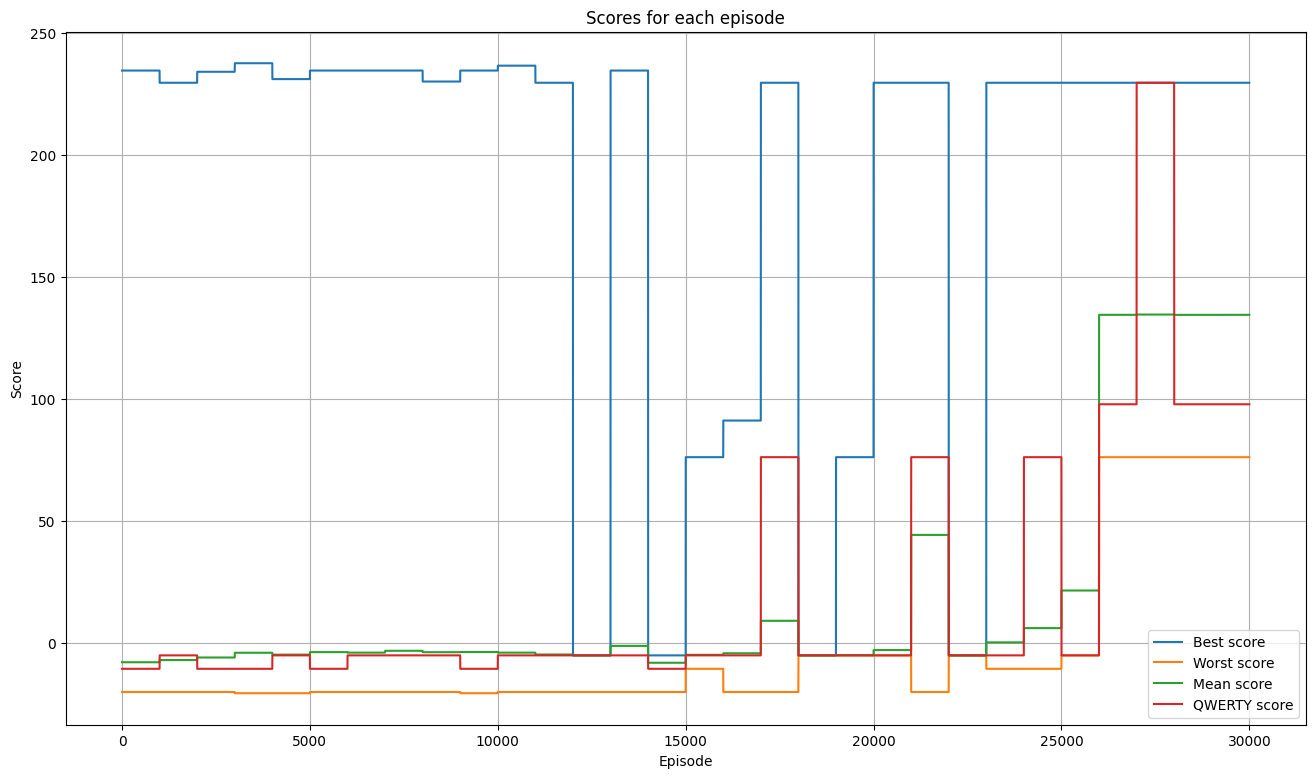

In [40]:
best_scores = [max(x) for x in train_rewars]
worst_scores = [min(x) for x in train_rewars]
mean_scores = [np.mean(x) for x in train_rewars]
qwerty_scores = [x[0] for x in train_rewars]

plt.subplots(1, 1, figsize=(16,9))
plt.plot(best_scores, label="Best score")
plt.plot(worst_scores, label="Worst score")
plt.plot(mean_scores, label="Mean score")
plt.plot(qwerty_scores, label="QWERTY score")

plt.legend()
plt.grid()
# plt.xlim([0, 500])
# plt.ylim([best_score, 14000])
plt.ylabel("Score")
plt.xlabel("Episode")
plt.title("Scores for each episode")
plt.show()

